In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, UpSampling2D, Flatten, LSTM, Dense, RepeatVector, Reshape

# **Data Preprocessing**

In [ ]:
n_frames = 10               # Number of frames per video sequence
height, width = 64, 64      # Frame dimensions
channels = 3                # RGB channels

In [ ]:
def load_video_frames(video_path, n_frames=10, frame_size=(64, 64)):

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Select n evenly spaced frame indices
    frame_indices = np.linspace(0, total_frames - 1, n_frames).astype(int)
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, frame_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    cap.release()
    # If not enough frames are read, repeat the last frame
    while len(frames) < n_frames:
        frames.append(frames[-1])
    frames = np.array(frames, dtype=np.float32) / 255.0  # Normalize to [0, 1]
    return frames


In [ ]:
def load_dataset(dataset_dir, n_frames=10, frame_size=(64, 64)):

    video_sequences = []
    for filename in os.listdir(dataset_dir):
        if filename.endswith('.mp4') or filename.endswith('.avi'):
            video_path = os.path.join(dataset_dir, filename)
            frames = load_video_frames(video_path, n_frames, frame_size)
            video_sequences.append(frames)
    video_sequences = np.array(video_sequences)
    # Final shape: (num_videos, n_frames, height, width, channels)
    return video_sequences


In [ ]:
dataset_dir = '/content/drive/My Drive/dataset/Avenue_Dataset/Avenue_Dataset/training_videos'
video_sequences = load_dataset(dataset_dir, n_frames, (height, width))
print("Dataset shape:", video_sequences.shape)


Dataset shape: (16, 10, 64, 64, 3)


# **CNN-LSTM Autoencoder Model**

In [ ]:
def build_autoencoder(n_frames, height, width, channels):
    input_frames = Input(shape=(n_frames, height, width, channels))

    # CNN Encoder: Process each frame individually
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(input_frames)
    x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)

    # Save shape for later use in the decoder
    shape_before_flatten = tf.keras.backend.int_shape(x)

    # Flatten the CNN output for each frame
    x = TimeDistributed(Flatten())(x)

    # LSTM Encoder: Capture temporal dependencies
    encoded = LSTM(128, activation='relu', return_sequences=False)(x)

    # Repeat the encoded vector to match the number of frames
    repeated = RepeatVector(n_frames)(encoded)

    # LSTM Decoder: Reconstruct the sequence of features
    x = LSTM(128, activation='relu', return_sequences=True)(repeated)

    # Recover the flattened CNN feature dimensions
    flattened_dim = shape_before_flatten[2] * shape_before_flatten[3] * shape_before_flatten[4]
    x = TimeDistributed(Dense(flattened_dim, activation='relu'))(x)

    # Reshape back to the CNN feature map dimensions
    x = TimeDistributed(Reshape((shape_before_flatten[2], shape_before_flatten[3], shape_before_flatten[4])))(x)

    # CNN Decoder: Reconstruct the original frames
    x = TimeDistributed(UpSampling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(UpSampling2D((2, 2)))(x)
    decoded_frames = TimeDistributed(Conv2D(channels, (3, 3), activation='sigmoid', padding='same'))(x)

    autoencoder = Model(inputs=input_frames, outputs=decoded_frames)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    return autoencoder

autoencoder = build_autoencoder(n_frames, height, width, channels)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 10, 64, 64, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_55                  │ (None, 10, 64, 64, 32)      │             896 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_56                  │ (None, 10, 32, 32, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_57                  │ (None, 10, 32, 32, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_58                  │ (None, 10, 16, 16, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_59                  │ (None, 10, 16384)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 128)                 │       8,454,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_5 (RepeatVector)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 10, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_60                  │ (None, 10, 16384)           │       2,113,536 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_61                  │ (None, 10, 16, 16, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_62                  │ (None, 10, 32, 32, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_63                  │ (None, 10, 32, 32, 64)      │          36,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_64                  │ (None, 10, 64, 64, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_65                  │ (None, 10, 64, 64, 3)       │           1,731 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,757,827 (41.04 MB)

 Trainable params: 10,757,827 (41.04 MB)

 Non-trainable params: 0 (0.00 B)

# **Model Training**

In [198]:
history = autoencoder.fit(video_sequences, video_sequences,
                          epochs=100,
                          batch_size=4,
                          validation_split=0.1)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0023 - val_loss: 0.0084
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0023 - val_loss: 0.0085
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0023 - val_loss: 0.0083
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0024 - val_loss: 0.0085
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0022 - val_loss: 0.0085
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0023 - val_loss: 0.0084
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0024 - val_loss: 0.0084
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0025 - val_loss: 0.0085
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0024 - val_loss: 0.0085
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0023 - val_loss: 0.0084
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0023 - val_loss: 0.0085
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0024 - val_lo

# **Anomaly Detection**

In [205]:
test_video = load_video_frames('/content/drive/My Drive/dataset/Avenue_Dataset/Avenue_Dataset/testing_videos/01.avi', n_frames, (height, width))
test_video = np.expand_dims(test_video, axis=0)  # add batch dimension

reconstructed_video = autoencoder.predict(test_video)
reconstruction_error = np.mean((test_video - reconstructed_video) ** 2)
print("Reconstruction error:", reconstruction_error)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Reconstruction error: 0.0136347


## **Visualizing Training progress**

In [206]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

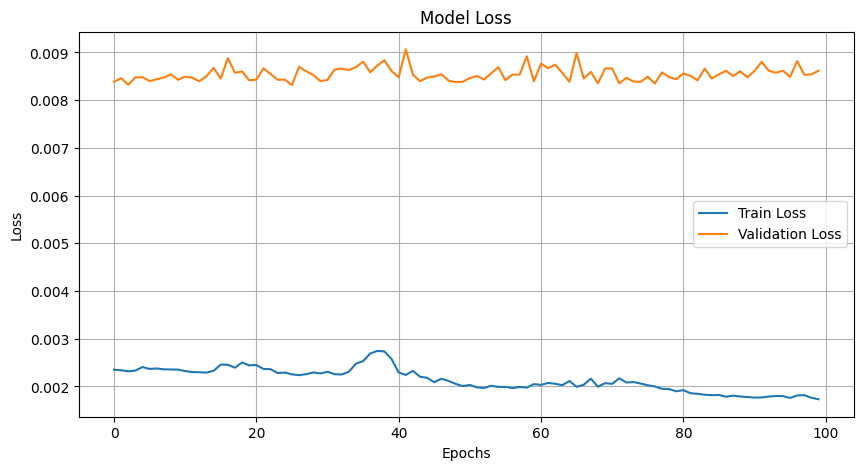

In [207]:
#  Plot Training & Validation Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.show()


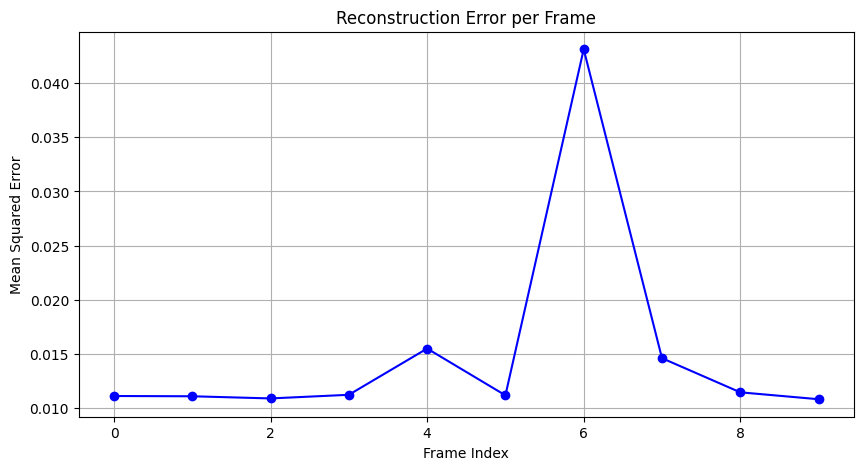

In [208]:
# Plot the reconstruction error for each frame
plt.figure(figsize=(10, 5))
plt.plot(frame_errors, marker='o', linestyle='-', color='b')
plt.xlabel('Frame Index')
plt.ylabel('Mean Squared Error')
plt.title('Reconstruction Error per Frame')
plt.grid(True)
plt.show()
